In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets

In [4]:
labels_map = {
    0: "Anthracnose",
    1: "Banana Fruit-Scarring Beetle",
    2: "Banana Skipper Damage",
    3: 'Banana Split Peel',
    4: "Black and Yellow Sigatoka",
    5: "Chewing insect damage on banana leaf",
    6: "Healthy Banana",
    7: "Healthy Banana leaf",
    8: "Panama Wilt Disease",
}
root_dir="/home/jovyan/bananadata"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:

dataset_path = root_dir+'/bananadata/AUGMENTED/data'
build_path = root_dir+'/bananadata/build/augs'

In [ ]:

NUM_CLASSES = 9
batch_size = 64
EPOCHS = 10 # Try increasing epochs to 30
LEARNING_RATE = 0.01
PATCH_SIZE = 16
IMAGE_SIZE = 224 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

In [7]:
normalize = transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    )
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize
    ])

In [8]:
dataset_train = datasets.ImageFolder(root=dataset_path+'/train', transform=transform)
dataset_val = datasets.ImageFolder(root=dataset_path+'/validation', transform=transform)
dataset_test = datasets.ImageFolder(root=dataset_path+'/test', transform=transform)
build_train = datasets.ImageFolder(root=build_path, transform=transform)

In [9]:
load_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
load_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
load_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
load_build = DataLoader(build_train, batch_size=batch_size, shuffle=True)

# VISION TRANSFORMER

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 img_size,
                 patch_size,
                 in_channels,
                 embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x) # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2) # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x

In [11]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [12]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [13]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)


In [14]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)
total_step = len(load_train)

In [62]:
# only run this if there is already a saved model in the directory
model_path = root_dir + '/bananadata/results/vit/models/VITmodel1.pth' # Replace with proper name of saved model
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
optimizer.load_state_dict(torch.load(root_dir + '/bananadata/results/vit/models/optimizer1.pth')) # replace this with proper name of saved model

In [ ]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, batch in enumerate(load_train):
        # Move tensors to the configured device
        images = batch[0].to(device)
        labels = batch[1].to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(load_train.dataset)
    train_losses.append(train_loss)

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, EPOCHS, i+1, total_step, loss.item()))

    # Validation
    running_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in load_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * labels.size(0)
            del images, labels, outputs
        val_loss = running_loss / len(load_val.dataset)
        val_losses.append(val_loss)
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        print('Accuracy of the network on the {} validation images: {} %'.format(945, 100 * correct / total))

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

[1.5902373888710468]
[1.5581802129745483]


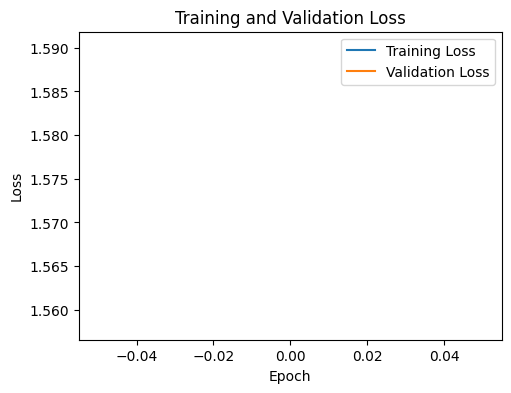

In [55]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
print(train_losses)
print(val_losses)

In [15]:
model.eval()
test_y_true = []
test_y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for batch in load_test:
        images = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_y_true.extend(labels.cpu().numpy())
        test_y_pred.extend(predicted.cpu().numpy())

        del images, labels, outputs

KeyboardInterrupt: 

Accuracy of the network on the 1024 test images: 36.65628245067497 %


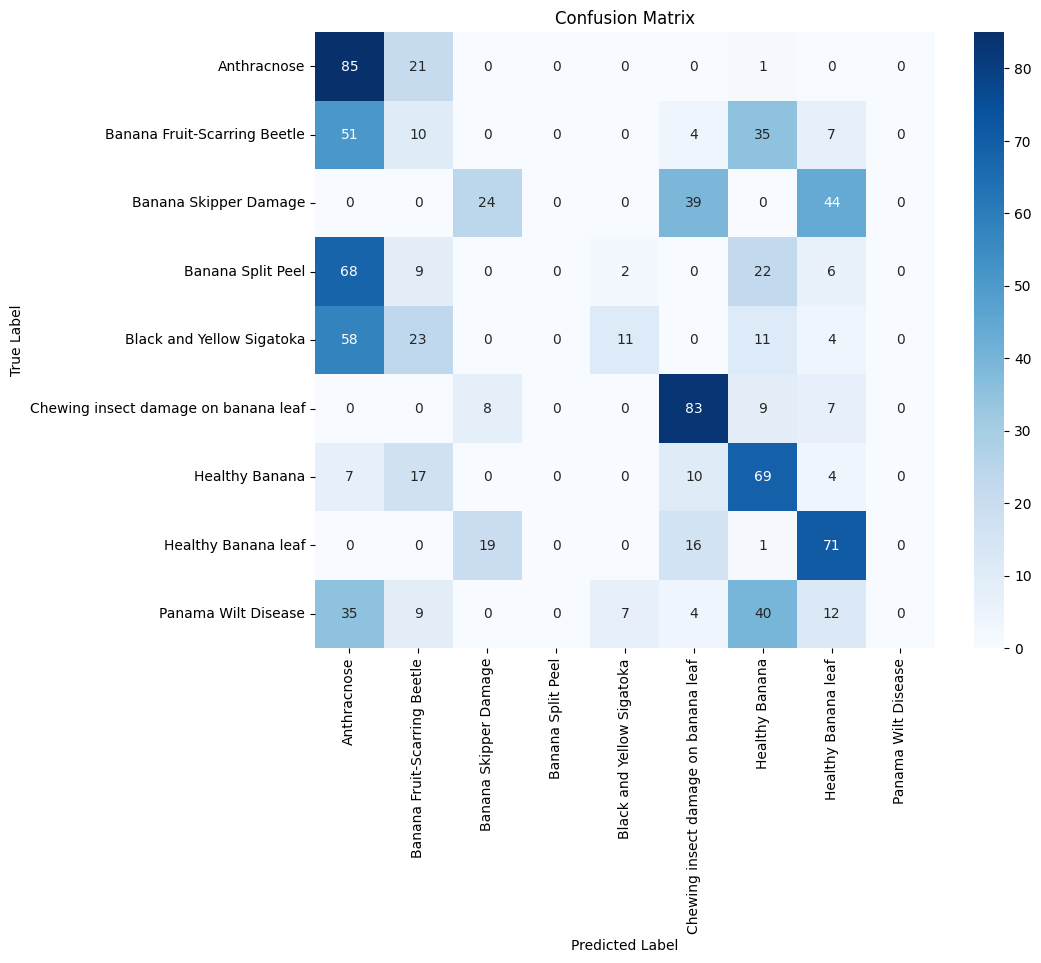

In [57]:
print('Accuracy of the network on the {} test images: {} %'.format(len(load_test)*batch_size, 100 * correct / total))

cm = confusion_matrix(test_y_true, test_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
model.eval()
build_y_true = []
build_y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    # change to buuild dataset
    for images, labels in load_build:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        build_y_true.extend(labels.cpu().numpy())
        build_y_pred.extend(predicted.cpu().numpy())
        del images, labels, outputs


KeyboardInterrupt: 

Accuracy of the network on the 384 build images: 15.277777777777779 %
[[12 10  0  0  9  2  7  0  0]
 [16  6  0  0  7  3  8  0  0]
 [ 0  0  0  0  0 26 14  0  0]
 [10  8  1  0 13  4  4  0  0]
 [ 7 17  1  0  4  3  8  0  0]
 [ 2  1  2  0  1 20 13  1  0]
 [13  5  0  0  8  2 12  0  0]
 [ 1  5  7  0  1 19  6  1  0]
 [ 8 19  0  0  2  2  9  0  0]]


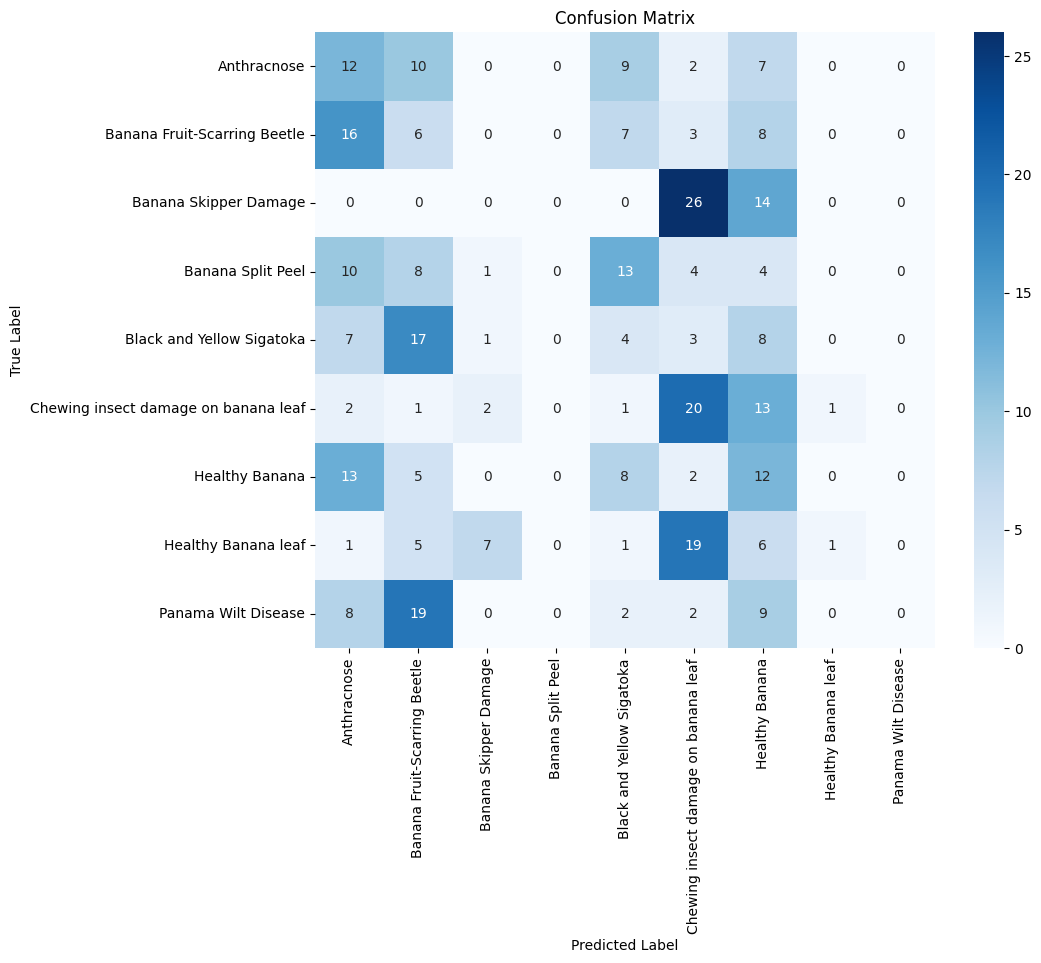

In [59]:
print('Accuracy of the network on the {} build images: {} %'.format(len(load_build)*batch_size, 100 * correct / total))

cm = confusion_matrix(build_y_true, build_y_pred)
print(cm)
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import json
import os
import uuid
from datetime import datetime
# Define the directory to save the results
results_dir = root_dir+"/bananadata/results/vit"
os.makedirs(results_dir, exist_ok=True)

dt = datetime.now()
# Define hyperparameters and results
hyperparameters = {
    "datetime": str(dt),
    "learning_rate": LEARNING_RATE,
    "epoch": EPOCHS,
    "batch_size": batch_size,
    "patch_size": PATCH_SIZE,
    "num_classes": NUM_CLASSES,
    "image_size": IMAGE_SIZE,
    "optimizer": "ADAM",
    "loss_function": "CrossEntropyLoss",
    "model_architecture": "Vision Transformer"
}

results = {
    "datetime": str(dt),
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "test_y_true": [int(x) for x in test_y_true], # Convert to int
    "test_y_pred": [int(x) for x in test_y_pred], # Convert to int
    "build_y_true": [int(x) for x in build_y_true], # Convert to int
    "build_y_pred": [int(x) for x in build_y_pred], # Convert to int
}

test_index = str(uuid.uuid4()).split('-')[0]
# Save hyperparameters
hyperparameters_path = os.path.join(results_dir, f"hyperparameters{test_index}.json")
with open(hyperparameters_path, "w") as f:
    json.dump(hyperparameters, f, indent=4)
print(f"Hyperparameters saved to {hyperparameters_path}")

# Save results
results_path = os.path.join(results_dir, f"results{test_index}.json")
with open(results_path, "w") as f:
    json.dump(results, f)
print(f"Results saved to {results_path}")

Hyperparameters saved to /home/jovyan/bananadata/bananadata/results/vit/hyperparameters2.json
Results saved to /home/jovyan/bananadata/bananadata/results/vit/results2.json


In [18]:
save_dir = results_dir+"/models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"VITmodel{test_index}.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /home/jovyan/bananadata/bananadata/results/vit/models/VITmodel2.pth


In [19]:
transform_path = os.path.join(save_dir, f"transform{test_index}.pth")
torch.save(transform, transform_path)
print(f"Transform saved to {transform_path}")

Transform saved to /home/jovyan/bananadata/bananadata/results/vit/models/transform2.pth


In [20]:
optimizer_path = os.path.join(save_dir, f"optimizer{test_index}.pth")
torch.save(optimizer.state_dict(), optimizer_path)
print(f"Optimizer saved to {optimizer_path}")


Optimizer saved to /home/jovyan/bananadata/bananadata/results/vit/models/optimizer2.pth
